# Configuration

NOTES: The warnings after the import are referred to the fact that Tensorflow 2.x versions are built to directly look for a GPU in the system. The warning can be forgot if you are not going to use the GPU. 

In [1]:
!source myenv/bin/activate

In [2]:
LENGTH_CHOSEN = 126520

In [3]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle
import scipy
import ipywidgets
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

2021-08-30 11:15:05.207607: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 11:15:05.207630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-30 11:15:06.056241: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-30 11:15:06.056812: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-30 11:15:06.127513: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-30 11:15:06.127533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (helemanc-Latitude-5410): /pr

[]

# Get data from dataset - Normalized Audio Folder 

In [4]:
main_path ='/home/helemanc/Desktop/Binary_Model/normalized_audio/ravdess' 

In [5]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

paths = []

for root, dirs, files in tqdm(os.walk(main_path)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            if file not in paths: 
                modality.append(modal)
                voc_channel.append(vchan)
                emotion.append(lab) #only labels
                intensity.append(ints)
                phrase.append(phr)
                actors.append(act)

                paths.append(file)
                full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

1it [00:00, 49.26it/s]


In [6]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [7]:
df.shape

(1440, 8)

In [8]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [9]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [10]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [11]:
RAV_df

,emotion_label,actors,gender,path
0,happy,16,female,/home/helemanc/Desktop/Binary_Model/normalized...
1,fear,16,female,/home/helemanc/Desktop/Binary_Model/normalized...
2,happy,2,female,/home/helemanc/Desktop/Binary_Model/normalized...
3,angry,17,male,/home/helemanc/Desktop/Binary_Model/normalized...
4,disgust,19,male,/home/helemanc/Desktop/Binary_Model/normalized...
...,...,...,...,...
1435,fear,19,male,/home/helemanc/Desktop/Binary_Model/normalized...
1436,neutral,2,female,/home/helemanc/Desktop/Binary_Model/normalized...
1437,fear,12,female,/home/helemanc/Desktop/Binary_Model/normalized...
1438,sadness,22,female,/home/helemanc/Desktop/Binary_Model/normalized...


In [12]:
RAV_train = []
RAV_val = []
RAV_test = []

In [13]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [14]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [15]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [16]:
df_train = RAV_train.reset_index(drop=True) 
df_val = RAV_val.reset_index(drop=True) 
df_test = RAV_test.reset_index(drop=True) 

## Utils

In [23]:
def load_files(df):
    X = []
    for i in tqdm(df['path']): 
        X.append(librosa.load(i, res_type='kaiser_fast', sr=16000))
    return X

def extract_samples(X): 
    samples = []
    for ind,i in enumerate(X):
        samples.append(i[0])
    return samples 

def extract_labels(df): 
    labels = df['emotion_label'].copy()
    return labels 

def compute_lengths(samples): 
    lengths = [len(x) for x in samples]
    return lengths 

def check_outliers(lengths):
    # outliers
    lengths = np.array(lengths)
    print((lengths > 300000).sum())
    new_lengths = lengths[lengths < 300000]
    return new_lengths 

def compute_mean_length(lengths): 
    return lengths.mean()

def cut_and_pad(samples, labels, length_chosen = LENGTH_CHOSEN): 
    X_new = []
    y_new = []
    count = 0 
    for ind,i in enumerate(samples):
        if i.shape[0] < 300000:
            if i.shape[0] > length_chosen:
                new = i[:length_chosen]
                X_new.append(new)
            elif i.shape[0] < length_chosen:
                new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
                X_new.append(new)
            else:
                X_new.append(i)
            y_new.append(labels[count])
        count+=1
    
    return X_new, y_new

# Data Augmentation 
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Data Augmentation 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
def compute_mfccs(samples): 
    mfccs = []
    for i in tqdm(samples):
        mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
        mfcc = mfcc.T
        mfcc = np.array(mfcc)
        mfccs.append(mfcc[:, 1:])
    mfccs = np.array(mfccs)
    return mfccs

def compute_mfccs_augmentation(samples, labels): 
    mfccs = []
    counter = 0 
    for i in tqdm(samples):

       # Weiner Filtering on original noise 
        samples_weiner = scipy.signal.wiener(i)
        is_fin = np.isfinite(samples_weiner).all()


        # Data Augmentation - Noise 
        noise_audio = noise(samples_weiner)

        # Data Augmentation - Pitch 
        pitch_audio = pitch(samples_weiner, sampling_rate=16000)


        # Data Augmentation -  pitch + noise 
        pn = pitch(noise_audio, sampling_rate = 16000)


        if is_fin: 
          # MFCC

          mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
          mfcc = mfcc.T
          mfccs.append(mfcc[:, 1:])

          mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=16000, n_mfcc=13)
          mfcc_augmented = mfcc_augmented.T
          mfccs.append(mfcc_augmented[:, 1:])

          mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_pitch = mfcc_augmented_pitch.T
          mfccs.append(mfcc_augmented_pitch[:, 1:])

          mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_p = mfcc_augmented_p.T
          mfccs.append(mfcc_augmented_p[:, 1:]) 

          mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=16000, n_mfcc=13)
          mfcc_augmented_pn = mfcc_augmented_pn.T
          mfccs.append(mfcc_augmented_pn[:, 1:]) 
    
    mfccs = np.array(mfccs)
    
    # Copy labels 
    y_prov = []
    y = labels 
    for i in range(len(y)): 
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
    y = np.asarray(y_prov)

    return mfccs, y 





# Feature extraction

In [24]:
df_train['emotion_label'].unique()

array(['happy', 'fear', 'angry', 'disgust', 'sadness', 'surprise', 'calm',
       'neutral'], dtype=object)

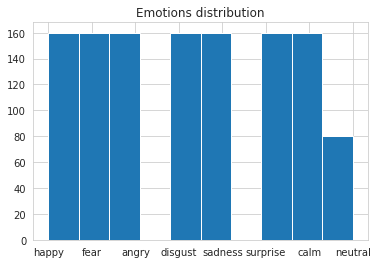

In [25]:
plt.title('Emotions distribution')
plt.hist(df_train['emotion_label'])
# plt.hist(y)
plt.show()

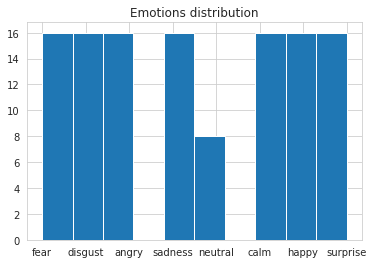

In [26]:
plt.title('Emotions distribution')
plt.hist(df_val['emotion_label'])
# plt.hist(y)
plt.show()

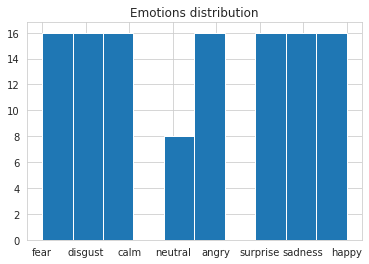

In [27]:
plt.title('Emotions distribution')
plt.hist(df_test['emotion_label'])
# plt.hist(y)
plt.show()

In [28]:
load_train = load_files(df_train)

100%|█████████████████████████████████████| 1200/1200 [00:00<00:00, 3850.40it/s]


In [29]:
samples_train = extract_samples(load_train)

In [30]:
labels_train = extract_labels(df_train)

## Train

In [31]:
lengths = compute_lengths(samples_train) 

In [32]:
new_lengths = check_outliers(lengths) 

0


In [33]:
mean_length = compute_mean_length(new_lengths)

In [34]:
mean_length

58883.15416666667

### Decide length

In [35]:
samples_train, labels_train = cut_and_pad(samples_train, labels_train)

In [36]:
samples_train = np.array(samples_train)
labels_train = np.array(labels_train)
print(samples_train.shape, labels_train.shape)

(1200,) (1200,)


In [37]:
mean_length = compute_mean_length(new_lengths)

In [38]:
mfccs_train = compute_mfccs(samples_train)

100%|███████████████████████████████████████| 1200/1200 [00:17<00:00, 69.53it/s]


In [39]:
mfccs_train.shape

(1200, 248, 12)

## Val

### Load samples and labels

In [40]:
load_val = load_files(df_val)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 1870.15it/s]


In [41]:
samples_val = extract_samples(load_val)

In [42]:
labels_val = extract_labels(df_val)

### Cut and Pad 

In [43]:
samples_val, labels_val = cut_and_pad(samples_val, labels_val)

In [44]:
samples_val = np.array(samples_val)
labels_val = np.array(labels_val)
print(samples_val.shape, labels_val.shape)

(120,) (120,)


### Feature Extraction

In [45]:
mfccs_val = compute_mfccs(samples_val)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 66.25it/s]


In [46]:
mfccs_val.shape

(120, 248, 12)

### Save features and labels

In [ ]:
'''
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_val_path = os.path.join(preprocess_path,"mfccs_val.pkl")
labels_val_path = os.path.join(preprocess_path,"labels_val.pkl")

with open(mfccs_val_path, 'wb') as f:
        pickle.dump(mfccs_val , f)
        
with open(labels_val_path, 'wb') as f:
        pickle.dump(labels_val , f)
'''

## Test

### Load samples and labels

In [47]:
load_test = load_files(df_test)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 1721.68it/s]


In [48]:
samples_test = extract_samples(load_test)

In [49]:
labels_test = extract_labels(df_test)

### Cut and Pad 

In [50]:
samples_test, labels_test = cut_and_pad(samples_test, labels_test)

In [51]:
samples_test = np.array(samples_test)
labels_test = np.array(labels_test)
print(samples_test.shape, labels_test.shape)

(120,) (120,)


### Feature Extraction

In [52]:
mfccs_test = compute_mfccs(samples_test)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 72.11it/s]


In [ ]:
mfccs_test.shape

### Save features and labels

In [ ]:
'''
preprocess_path = "/home/helemanc/Desktop/Binary_Model/pre-processed"
mfccs_test_path = os.path.join(preprocess_path,"mfccs_test.pkl")
labels_test_path = os.path.join(preprocess_path,"labels_test.pkl")

with open(mfccs_test_path, 'wb') as f:
        pickle.dump(mfccs_test , f)
        
with open(labels_test_path, 'wb') as f:
        pickle.dump(labels_test , f)
'''

# Encode Labels - Binary 

In [53]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [55]:
y_train = pd.Series(labels_train).replace(emotion_enc)
y_val = pd.Series(labels_val).map(emotion_enc)
y_test = pd.Series(labels_test).map(emotion_enc)
#y_train_aug = pd.Series(labels_train_aug).map(emotion_enc)

# Train, Val, Test (X) 

In [56]:
X_train = mfccs_train
X_val = mfccs_val
X_test = mfccs_test 

# Standard Scaling 

## Without Augmentation

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Model 

In [58]:
model = Sequential()

model.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(248,12), kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.6))

model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64,  kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 248, 256)          15616     
_________________________________________________________________
activation (Activation)      (None, 248, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 62, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0

2021-08-30 11:17:47.722081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-30 11:17:47.723150: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


# Training

## Without Augmentation

### Load Data

In [217]:
'''
X_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_train.pkl", 'rb'))
X_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_val.pkl", 'rb'))
X_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_test.pkl", 'rb'))
y_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_train.pkl", 'rb'))
y_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_val.pkl", 'rb'))
y_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_test.pkl", 'rb'))
'''

'\nX_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_train.pkl", \'rb\'))\nX_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_val.pkl", \'rb\'))\nX_test = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/X_test.pkl", \'rb\'))\ny_train = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_train.pkl", \'rb\'))\ny_val = pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_val.pkl", \'rb\'))\ny_test =  pickle.load(open( "/home/helemanc/Desktop/Binary_Model/data_model/y_test.pkl", \'rb\'))\n'

In [59]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [60]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [64]:
import datetime, os

In [65]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [66]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-08-30 11:19:21.639530: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-30 11:19:21.639603: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-30 11:19:21.698505: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [67]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [68]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics='accuracy')

### Train

In [69]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint, tensorboard_callback], class_weight = class_weights)

2021-08-30 11:20:28.806988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-30 11:20:28.834188: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/500
 39/300 [==>...........................] - ETA: 1s - loss: 7.1871 - accuracy: 0.4840

2021-08-30 11:20:29.274020: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-30 11:20:29.274067: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-30 11:20:29.280416: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-08-30 11:20:29.283094: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-08-30 11:20:29.287012: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210830-111921/train/plugins/profile/2021_08_30_11_20_29
2021-08-30 11:20:29.287750: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210830-111921/train/plugins/profile/2021_08_30_11_20_29/helemanc-Latitude-5410.trace.json.gz
2021-08-30 11:20:29.292265: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210830-111921/train/plugins/p

300/300 [==============================] - 2s 6ms/step - loss: 3.4411 - accuracy: 0.5401 - val_loss: 0.6716 - val_accuracy: 0.5917
Epoch 2/500
300/300 [==============================] - 2s 5ms/step - loss: 0.6732 - accuracy: 0.6223 - val_loss: 0.6499 - val_accuracy: 0.7333
Epoch 3/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6174 - accuracy: 0.6519 - val_loss: 0.6399 - val_accuracy: 0.6917
Epoch 4/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6002 - accuracy: 0.6808 - val_loss: 0.6131 - val_accuracy: 0.7667
Epoch 5/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6527 - val_loss: 0.6309 - val_accuracy: 0.6833
Epoch 6/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6004 - accuracy: 0.6860 - val_loss: 0.5177 - val_accuracy: 0.7333
Epoch 7/500
300/300 [==============================] - 1s 5ms/step - loss: 0.6263 - accuracy: 0.6759 - val_loss: 0.5574 - val_accuracy: 0.6667
Epoch 8/500

In [70]:
%tensorboard --logdir logs

In [71]:
model.evaluate(X_test, y_test, batch_size=8)

15/15 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8083


[0.4256199598312378, 0.8083333373069763]

In [74]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        56
           1       0.86      0.77      0.81        64

    accuracy                           0.81       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.81      0.81      0.81       120

